## Imports and functions

In [2]:
import numpy as np
import ot
import pandas as pd
import matplotlib.pyplot as plt
from utils.Visualizations import *
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def run_experiment_and_append_images(df, im1, im2,noise_param):
    results_classic = []
    results_noised = []
    ratios_emd = []
    results_linear = []
    results_linear_noised = []
    ratios_linear = []
    diff_classics = []
    diff_posts = []

    for i in range(100):
        im1_post, im2_post, C = create_images_and_costs(im1_base=im1, im2_base=im2, noise=noise_param)

        results_classic_add = calc_transport_pot_emd(im1.flatten(), im2.flatten(), C)[1]
        results_noised_add = calc_transport_pot_emd(im1_post.flatten(), im2_post.flatten(), C)[1]

        results_classic.append(results_classic_add)
        results_noised.append(results_noised_add)
        ratios_emd.append(results_classic_add / results_noised_add)

        results_linear.append(np.linalg.norm(im1 - im2))
        results_linear_noised.append(np.linalg.norm(im1_post - im2_post))
        ratios_linear.append(np.linalg.norm(im1 - im2) / np.linalg.norm(im1_post - im2_post))

    # Create new row
    new_row = {
        'Noise_Param': noise_param,
        'Distances_Classic': np.mean(results_classic),
        'Distances_Noised': np.mean(results_noised),
        'Ratios_EMD': np.mean(ratios_emd),
        'Distances_Linear': np.mean(results_linear),
        'Distances_Linear_Noised': np.mean(results_linear_noised),
        'Ratios_Linear': np.mean(ratios_linear)
    }

    # Append new row to DataFrame
    return df._append(new_row, ignore_index=True)

In [4]:
def create_images_and_costs(im1_base, im2_base, noise, distance_metric='L1'):
    """
    This function creates two 1D distributions and a cost matrix between them.
    :param noise: noise parameter
    :param distance_metric: distance metric to use
    :return: p, q, C
    """
    C = calculate_costs(im1_base.shape)

    im1_noised = noise_image(im1_base, noise) 
    im2_noised = noise_image(im2_base, noise)

    im1_pos, im1_neg = split_signed_measure(im1_noised)
    im2_pos, im2_neg = split_signed_measure(im2_noised)

    im1_post = im1_pos + im2_neg
    im2_post = im1_neg + im2_pos

    mean_distribs = (im2_post.sum() + im1_post.sum()) / 2
    im1_post = im1_post * (mean_distribs / im1_post.sum())
    im2_post = im2_post * (mean_distribs / im2_post.sum())
    
    return im1_post, im2_post, C

## Single Image

In [5]:
im1 = np.zeros([20,20])
im1[0:4,0:4] = 1
im2 = np.zeros([20,20])
im2[4:8,8:12] = 1

noise_param = 1e-3

In [6]:
im1_post, im2_post, C = create_images_and_costs(im1_base=im1, im2_base=im2, noise=noise_param)

In [7]:
im1_noisy = noise_image(im1, noise_param)  # Wondering whether I should normalize the images before noising them?4
im2_noisy = noise_image(im2, noise_param)

im1_pos, im1_neg = split_signed_measure(im1_noisy)
im2_pos, im2_neg = split_signed_measure(im2_noisy)

im1_post = im1_pos + im2_neg
im2_post = im1_neg + im2_pos

mean_distribs = (im2_post.sum() + im1_post.sum()) / 2
im1_post = im1_post * (mean_distribs / im1_post.sum())
im2_post = im2_post * (mean_distribs / im2_post.sum())

In [8]:
C = calculate_costs(im1.shape)

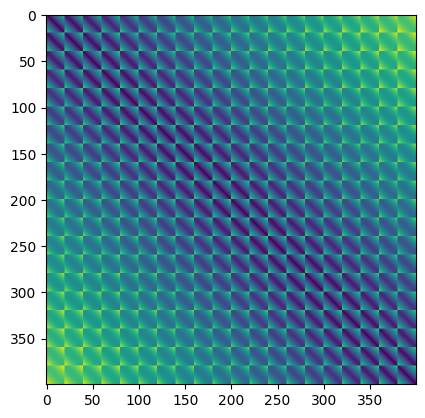

In [9]:
plt.imshow(C)

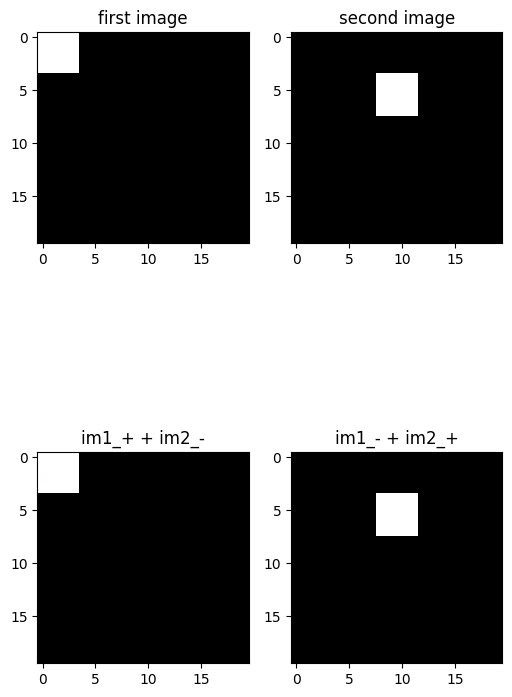

In [10]:
fig = plt.figure(figsize=(6, 10))

fig.add_subplot(2, 2, 1)
plt.title('first image')
plt.imshow(im1, cmap='gray')

fig.add_subplot(2, 2, 2)
plt.title('second image')
plt.imshow(im2, cmap='gray')

fig.add_subplot(2, 2, 3)
plt.title('im1_+ + im2_-')
plt.imshow(im1_post, cmap='gray')

fig.add_subplot(2, 2, 4)
plt.title('im1_- + im2_+')
plt.imshow(im2_post, cmap='gray')

In [11]:
results_classic = calc_transport_pot_emd(im1.flatten(), im2.flatten(), C)[1]
results_noised = calc_transport_pot_emd(im1_post.flatten(), im2_post.flatten(), C)[1]

print('Results on classic EMD:', results_classic)
print('Results on noised:', results_noised)
print('Ratio:', results_classic/results_noised)

print('Results on normal linear:', np.linalg.norm(im1-im2))
print('Results on linear noised:', np.linalg.norm(im1_post-im2_post))
print('Ratio:', np.linalg.norm(im1-im2)/np.linalg.norm(im1_post-im2_post))

Results on classic EMD: 143.10835055998655
Results on noised: 143.41612785385396
Ratio: 0.9978539561869844
Results on normal linear: 5.656854249492381
Results on linear noised: 5.655237990857117
Ratio: 1.0002857985177418


In [12]:
results_classic_add = calc_transport_pot_emd(im1.flatten(), im2.flatten(), C)[1]
results_noised_add = calc_transport_pot_emd(im1_post.flatten(), im2_post.flatten(), C)[1]

linear_distance = np.linalg.norm(im1 - im2)
linear_distance_post = np.linalg.norm(im1_post - im2_post)
linear_ratio = np.linalg.norm(im1 - im2) / np.linalg.norm(im1_post - im2_post)

In [13]:
results_classic_add

143.10835055998655

In [14]:
results_noised_add

143.41612785385396

## Multiple images, running 100 samples of noise on each pair of images

In [27]:
im1 = np.zeros([10,10])
im1[1:3,1:3] = 1
im2 = np.zeros([10,10])
im2[7:9,7:9] = 1

noise_param = 1

In [28]:
columns = ['Noise_Param', 'Distances_Classic', 'Distances_Noised', 'Ratios_EMD', 
           'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

noises = np.linspace(start=1e-3,stop=1, num=10)    

In [29]:
for noise in tqdm(noises):
    df = run_experiment_and_append_images(df, im1, im2, noise)

  0%|                                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_6300\2611460756.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.18it/s]


In [30]:
df.tail()

,Noise_Param,Distances_Classic,Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
5,0.556,33.941125,65.116551,0.548515,2.828427,8.406815,0.338007
6,0.667,33.941125,74.211032,0.479783,2.828427,9.751270,0.291964
7,0.778,33.941125,82.958584,0.421247,2.828427,11.448707,0.248161
8,0.889,33.941125,91.108245,0.383465,2.828427,12.896892,0.220369
9,1.000,33.941125,104.012712,0.338392,2.828427,14.312459,0.198630


In [31]:
df.head()

,Noise_Param,Distances_Classic,Distances_Noised,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,0.001,33.941125,33.978735,0.998894,2.828427,2.828412,1.000006
1,0.112,33.941125,38.582728,0.886522,2.828427,3.234836,0.876512
2,0.223,33.941125,43.150719,0.809910,2.828427,4.249228,0.668181
3,0.334,33.941125,47.850899,0.736018,2.828427,5.480943,0.518634
4,0.445,33.941125,57.816583,0.612019,2.828427,6.923185,0.410382


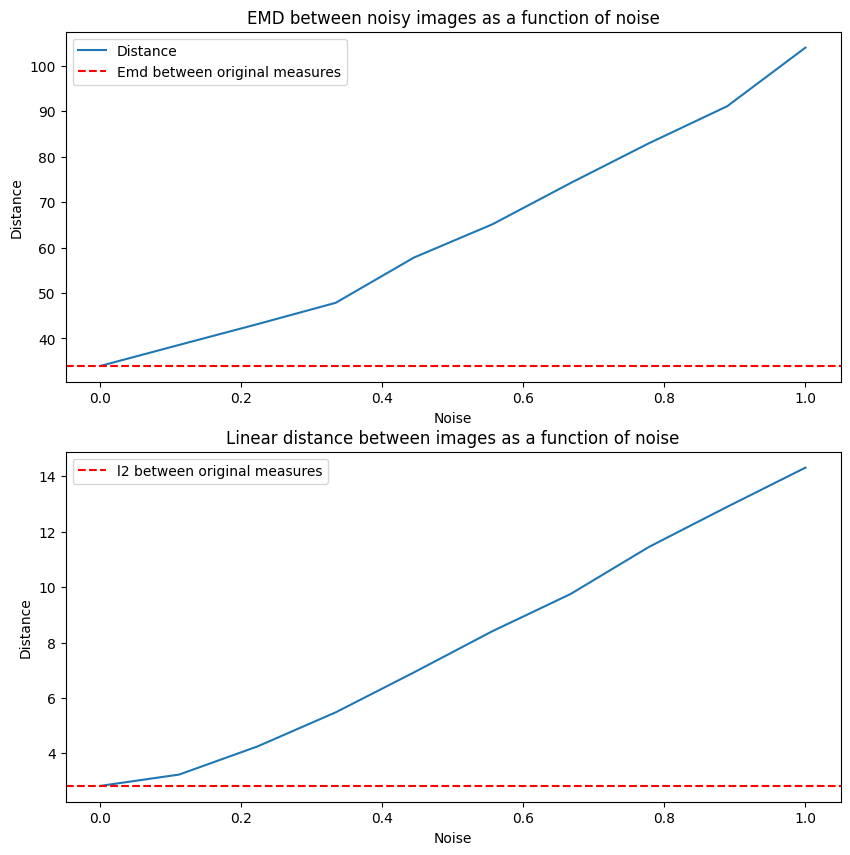

In [32]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(2,1,1)
plt.plot(df['Noise_Param'], df['Distances_Noised'], label='Distance')
#plt.xscale('log')
plt.title('EMD between noisy images as a function of noise')
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.axhline(y=df['Distances_Classic'][0], color='r', linestyle='--', label='Emd between original measures')
plt.legend()

fig.add_subplot(2,1,2)
plt.plot(df['Noise_Param'], df['Distances_Linear_Noised'])
#plt.xscale('log')
plt.title('Linear distance between images as a function of noise')
plt.xlabel('Noise')
plt.ylabel('Distance')
plt.axhline(y=df['Distances_Linear'][0], color='r', linestyle='--', label='l2 between original measures')
plt.legend()
plt.show()

In [33]:
noise = np.array(df['Noise_Param'])
emd = np.array(df['Distances_Noised'])
lin = np.array(df['Distances_Linear_Noised'])

In [34]:
slope_emd, intercept_emd = np.polyfit(noise, emd, 1)
print('The intercept for emd is', intercept_emd, 'and the slope is', slope_emd)

The intercept for emd is 28.80667492665664 and the slope is 70.07393407074589


In [38]:
slope_lin, intercept_lin = np.polyfit(noise, lin, 1)
print('The intercept for linear is', intercept_lin, 'and the slope is', slope_lin)

The intercept for linear is 1.9062068052303556 and the slope is 12.082053780026586


### If we normalize the intercept to 1, since we care about the precentage difference, we will get:

In [36]:
slope_emd, intercept_emd = np.polyfit(noise, emd, 1)
print('The intercept for emd is', 1, 'and the slope is', slope_emd/intercept_emd)

The intercept for emd is 1 and the slope is 2.43255892077645


In [37]:
slope_lin, intercept_lin = np.polyfit(noise, lin, 1)
print('The intercept for linear is', 1, 'and the slope is', slope_lin / intercept_lin)

The intercept for linear is 1 and the slope is 6.338270195487278


In [41]:
columns = ['Noise_Param', 'Distances_Classic', 'Distances_Noised', 'Ratios_EMD',
           'Distances_Linear', 'Distances_Linear_Noised', 'Ratios_Linear']
df = pd.DataFrame(columns=columns)

im_sizes = [10, 20, 50, 100]
noises = np.linspace(start=1e-3, stop=1, num=22)

for im_size in tqdm(im_sizes):
    im1 = np.zeros((im_size, im_size))
    im1[int(0.1 * im_size): int(0.3 * im_size), int(0.1 * im_size): int(0.3 * im_size)] = 1

    im2 = np.zeros((im_size, im_size))
    im2[int(0.7 * im_size): int(0.9 * im_size), int(0.7 * im_size): int(0.9 * im_size)] = 1

    for noise in noises:
        df = run_experiment_and_append_images(df, im1, im2, noise_param=noise)

  0%|                                                                                               | 0/4 [00:00<?, ?it/s]C:\Users\eriki\AppData\Local\Temp\ipykernel_6300\2611460756.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return df._append(new_row, ignore_index=True)
 50%|███████████████████████████████████████████▌                                           | 2/4 [00:29<00:33, 16.94s/it]C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\ot\lp\__init__.py:354: UserWarni